In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/home/beans/bespoke')

from constants import *
from traj_utils import *
import matplotlib.pyplot as plt

In [2]:
chunks_range = range(SEQ_LEN-1, EPISODE_LEN, SEQ_LEN)

In [3]:
all_aux = []
all_wp_angles = []
all_wp_dists = []
all_wp_rolls, all_wp_zs = [], []
all_run_paths = []
n_couldnt_load_runs = 0
for d in range(N_RUNNERS):
    datagen_id = ("00"+str(d))[-2:]
    for r in range(RUNS_TO_STORE_PER_PROCESS):
        run_path = f"/home/beans/blender_membank/dataloader_{datagen_id}/run_{r}"
        n_targets_paths_files = len(glob.glob(f"{run_path}/targets_*.npy"))
        targets_paths = [f'{run_path}/targets_{i}.npy' for i in chunks_range]
        
        if n_targets_paths_files < len(targets_paths):
            print(run_path)
            n_couldnt_load_runs += 1
            continue
            
        aux = np.concatenate([np.load(f'{run_path}/aux_{i}.npy') for i in chunks_range], axis=0)
        targets = np.concatenate([np.load(p) for p in targets_paths], axis=0)
        
        wp_angles, wp_dists, wp_rolls, wp_zs = np.split(targets, 4, axis=1)
        
        all_aux.append(aux)
        all_wp_angles.append(wp_angles)
        all_wp_dists.append(wp_dists)
        all_wp_rolls.append(wp_rolls)
        all_wp_zs.append(wp_zs)
        all_run_paths.append(run_path)
        
        
all_aux = np.stack(all_aux, axis=0)
all_wp_angles = np.stack(all_wp_angles, axis=0)
all_wp_dists = np.stack(all_wp_dists, axis=0)
all_wp_rolls = np.stack(all_wp_rolls, axis=0)
all_wp_zs = np.stack(all_wp_zs, axis=0)

print(f"couldn't load {n_couldnt_load_runs} out of {N_RUNNERS*RUNS_TO_STORE_PER_PROCESS} runs")

/home/beans/blender_membank/dataloader_00/run_5
/home/beans/blender_membank/dataloader_01/run_4
/home/beans/blender_membank/dataloader_02/run_5
/home/beans/blender_membank/dataloader_03/run_4
/home/beans/blender_membank/dataloader_04/run_4
/home/beans/blender_membank/dataloader_05/run_4
/home/beans/blender_membank/dataloader_06/run_4
/home/beans/blender_membank/dataloader_07/run_4
/home/beans/blender_membank/dataloader_08/run_5
/home/beans/blender_membank/dataloader_09/run_4
/home/beans/blender_membank/dataloader_10/run_4
/home/beans/blender_membank/dataloader_11/run_5
couldn't load 12 out of 360 runs


In [8]:
aux_model, aux_calib, aux_targets = get_auxs(all_aux)

In [41]:
speed_mask = get_speed_mask(aux_model)
speed_mask.shape

(359, 1, 30)

In [42]:
%%time
all_headings = get_headings_from_traj_batch(all_wp_angles, all_wp_dists)

CPU times: user 4.94 s, sys: 17 µs, total: 4.94 s
Wall time: 4.94 s


In [43]:
all_curvatures = get_curvatures_from_headings_batch(all_headings)

In [44]:
all_wp_angles.shape, all_wp_dists.shape, all_headings.shape, all_curvatures.shape

((359, 1160, 30), (359, 1160, 30), (359, 1160, 30), (359, 1160, 30))

In [45]:
mm = 0
for i in range(len(all_curvatures)):
    m = abs(all_curvatures[i]).max()
    if m > .1:
        print(i, m)
        mm += 1

101 0.17946291
199 0.11043912
246 0.15268254


In [46]:
all_run_paths[72]

'/home/beans/blender_membank/dataloader_02/run_12'

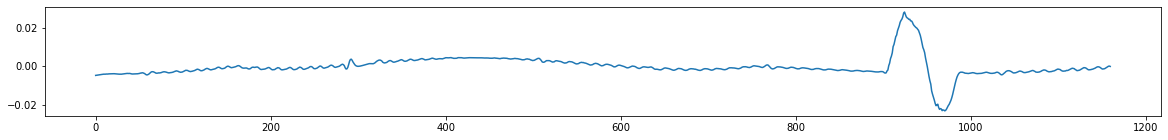

In [47]:
plt.figure(figsize=(20,2))
plt.plot(all_wp_angles[58,:,1])

<BarContainer object of 40 artists>

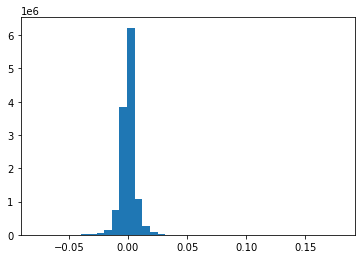

In [48]:
plt.hist(all_curvatures[:,:,:].flatten(), bins=40)[2]

In [49]:
all_curvatures[:,:,:].std()

0.0063098636

In [50]:
all_torques = []
all_tds = []
for i in range(len(all_aux)):
    speeds = all_aux[i, :, 2]
    wp_angles = gather_preds(all_wp_angles[i, :, :], speeds)
    torque = np.degrees(wp_angles) * speeds**2
    all_torques.append(torque)
    all_tds.append(torque[1:]-torque[:-1])
    
all_torques = np.concatenate(all_torques)
all_tds = np.concatenate(all_tds)

<BarContainer object of 40 artists>

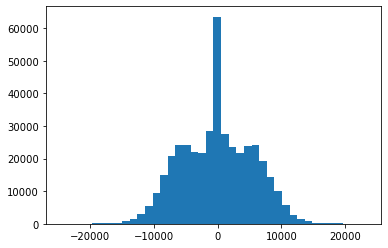

In [51]:
plt.hist(all_torques.flatten(), bins=40)[2]

<BarContainer object of 40 artists>

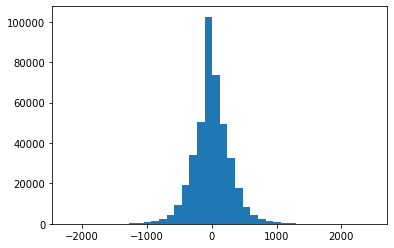

In [52]:
plt.hist(all_tds.flatten(), bins=40)[2]

In [53]:
np.quantile(abs(all_tds.flatten()), .999), np.quantile(abs(all_torques.flatten()), .999)

(1310.6058316054912, 18732.820445559984)

In [54]:
mean_dists = abs(all_wp_dists).mean(axis=0).mean(0)
mean_dists

array([  6.0009084,   7.0008807,   8.000791 ,   9.000612 ,  10.000348 ,
        10.999998 ,  11.999525 ,  12.998923 ,  13.998195 ,  14.997333 ,
        15.996309 ,  16.995153 ,  17.9938   ,  18.99228  ,  19.990585 ,
        20.98868  ,  21.986584 ,  22.984287 ,  23.981789 ,  24.979065 ,
        34.938843 ,  44.872654 ,  54.777737 ,  64.6524   ,  74.4954   ,
        84.30593  ,  94.084305 , 103.82986  , 113.54295  , 123.225174 ],
      dtype=float32)

<BarContainer object of 40 artists>

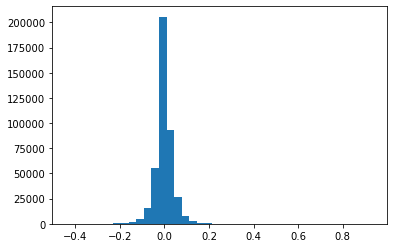

In [55]:
plt.hist(all_headings[:,:,0].flatten(), bins=40)[2]

In [56]:
all_headings[:,:,0].std()

0.041861765

In [57]:
mean_headings = abs(all_headings).mean(axis=0).mean(0)
mean_headings

array([0.02620808, 0.03038177, 0.03439521, 0.03841128, 0.04242161,
       0.04642422, 0.05041452, 0.05438932, 0.05834737, 0.06228894,
       0.06621339, 0.07011954, 0.07400665, 0.07787379, 0.08172107,
       0.08554865, 0.08935671, 0.09314513, 0.09691364, 0.1005872 ,
       0.13617635, 0.17011991, 0.2014737 , 0.23034373, 0.25690943,
       0.28114557, 0.3031044 , 0.32310602, 0.34172   , 0.35116717],
      dtype=float32)

In [58]:
mean_headings[-1] / mean_headings[0]

13.399197

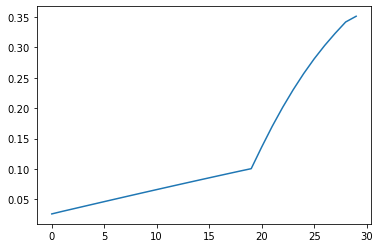

In [59]:
plt.plot(mean_headings)

In [60]:
mean_angles = abs(all_wp_angles).mean(axis=0).mean(0)
mean_angles

array([0.01302697, 0.01520142, 0.01733486, 0.01943924, 0.02152224,
       0.02358872, 0.02564185, 0.02768367, 0.02971509, 0.03173694,
       0.03374988, 0.03575401, 0.03774934, 0.03973567, 0.04171339,
       0.0436822 , 0.04564277, 0.04759526, 0.04953977, 0.05147587,
       0.07037009, 0.08841375, 0.10558271, 0.12183939, 0.13716398,
       0.15157099, 0.16507863, 0.17771888, 0.18953319, 0.20059983],
      dtype=float32)

In [61]:
mean_angles[-1] / mean_angles[0]

15.398806

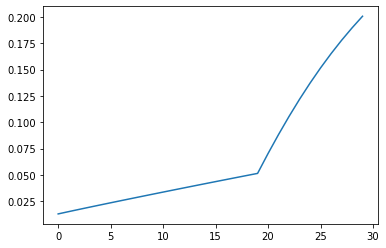

In [64]:
plt.plot(mean_angles)

<BarContainer object of 40 artists>

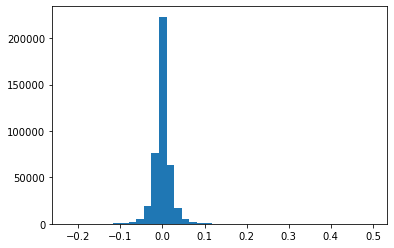

In [65]:
plt.hist(all_wp_angles[:,:,0].flatten(), bins=40)[2]

In [66]:
all_wp_angles[:,:,0].std()

0.021239085

<BarContainer object of 40 artists>

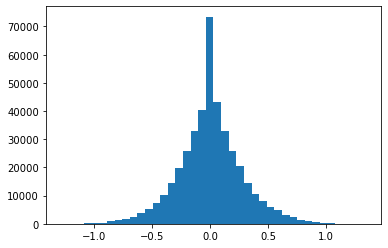

In [67]:
plt.hist(all_wp_angles[:,:,-1].flatten(), bins=40)[2]

<BarContainer object of 40 artists>

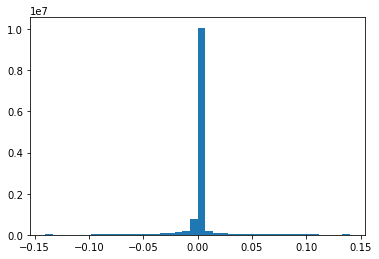

In [68]:
plt.hist(all_wp_rolls.flatten(), bins=40)[2]

In [69]:
all_wp_rolls.std()

0.022350611

<BarContainer object of 40 artists>

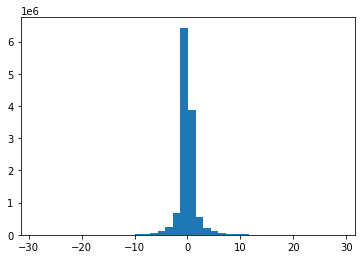

In [70]:
plt.hist(all_wp_zs.flatten(), bins=40)[2]

In [71]:
all_wp_zs.std()

1.8075916

<BarContainer object of 40 artists>

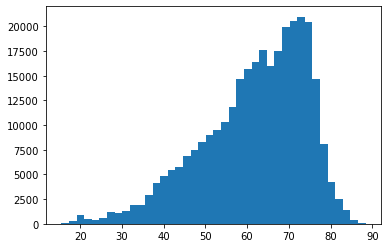

In [141]:
# speed
plt.hist(all_aux[:,:,2].flatten(), bins=40)[2]

<BarContainer object of 40 artists>

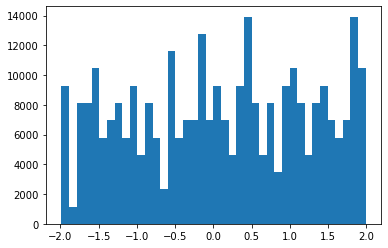

In [142]:
# pitch
plt.hist(all_aux[:,:,0].flatten(), bins=40)[2]

<BarContainer object of 40 artists>

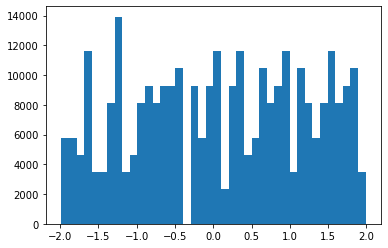

In [143]:
# yaw
plt.hist(all_aux[:,:,1].flatten(), bins=40)[2]

<BarContainer object of 40 artists>

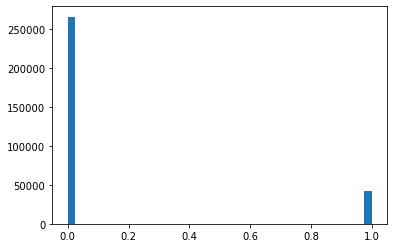

In [144]:
# approaching stop
plt.hist(all_aux[:,:,AUX_APPROACHING_STOP_IX].flatten(), bins=40)[2]

In [145]:
all_aux.shape

(265, 1160, 20)

<BarContainer object of 40 artists>

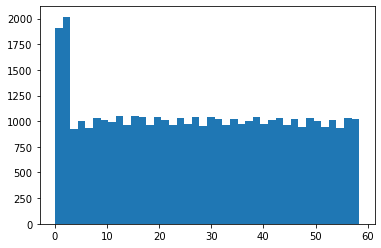

In [146]:
# stop dist
a = all_aux[:,:,AUX_STOP_DIST_IX].flatten()
a = a[a<150]
plt.hist(a, bins=40)[2]

<BarContainer object of 40 artists>

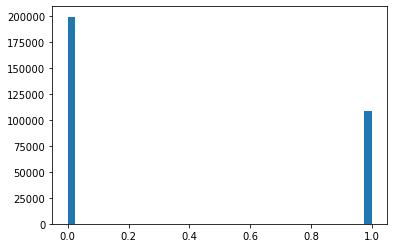

In [147]:
# lead car
a = all_aux[:,:,AUX_HAS_LEAD_IX].flatten()
plt.hist(a, bins=40)[2]

<BarContainer object of 40 artists>

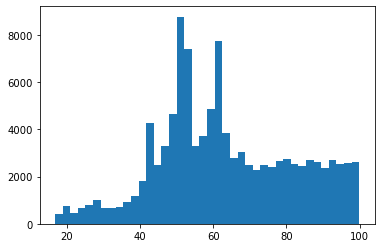

In [148]:
# lead dist
a = all_aux[:,:,AUX_LEAD_DIST_IX].flatten()
a = a[a<150]
plt.hist(a, bins=40)[2]

In [149]:
paths = glob.glob(f"{BLENDER_MEMBANK_ROOT}/**/episode_info.npy", recursive=True)
is_just_straight = np.array([np.load(p)[0] for p in paths])
is_just_straight.sum() / len(is_just_straight)

1.0